# HW3 Image Classification
## We strongly recommend that you run with [Kaggle](https://www.kaggle.com/t/86ca241732c04da99aca6490080bae73) for this homework

If you have any questions, please contact the TAs via TA hours, NTU COOL, or email to mlta-2023-spring@googlegroups.com

# Check GPU Type

In [1]:
!nvidia-smi

Tue Jun 11 01:09:05 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.76                 Driver Version: 551.76         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   43C    P8              2W /  104W |    4034MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Get Data
Notes: if the links are dead, you can download the data directly from Kaggle and upload it to the workspace, or you can use the Kaggle API to directly download the data into colab.


In [2]:
# Download Link
# Link 1 (Dropbox): https://www.dropbox.com/s/up5q1gthsz3v0dq/food-11.zip?dl=0
# Link 2 (Google Drive): https://drive.google.com/file/d/1tbGNwk1yGoCBdu4Gi_Cia7EJ9OhubYD9/view?usp=share_link
# Link 3: Kaggle Competition.

# (1) dropbox link
#!wget -O food11.zip https://www.dropbox.com/s/up5q1gthsz3v0dq/food-11.zip?dl=0

# (2) google drive link
#!pip install gdown --upgrade
#!gdown --id '1tbGNwk1yGoCBdu4Gi_Cia7EJ9OhubYD9' --output food11.zip

In [3]:
#!unzip food11.zip

# Import Packages

In [4]:
_exp_name = "sample"

In [1]:
# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset
# This is for the progress bar.
from tqdm.auto import tqdm
import random
# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter
#plot
import matplotlib.pyplot as plt
# Pretrained model
from torchvision.models import resnet34, resnet18, vgg16, densenet121, alexnet, squeezenet1_0

In [2]:
myseed = 6666  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# Transforms
Torchvision provides lots of useful utilities for image preprocessing, data *wrapping* as well as data augmentation.

Please refer to PyTorch official website for details about different transforms.

In [3]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    # You may add some transforms here.
    transforms.RandomRotation(40),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize((224, 224)),
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
    
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    
])

# Datasets
The data is labelled by the name, so we load images and label while calling '__getitem__'

In [4]:
from pathlib import Path   # new for windows

class FoodDataset(Dataset):
    def __init__(self,path=None, tfm=test_tfm, files = None):
        super(FoodDataset).__init__()
        # self.path = path
        if path is not None:
            self.path = Path(path)
            # self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
            self.files = sorted([self.path.joinpath(child.name) for child in self.path.iterdir() if str(child).endswith(".jpg")])     # NEW: use the pathlib library
        else:
            self.files = files
        
        self.transform = tfm
        print(f'data length: {len(self.files)}')
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        # fname = self.files[idx]
        # im = Image.open(fname)
        # im = self.transform(im)
        
        # try:
        #     label = int(fname.split("\\")[-1].split("_")[0])
        # except:
        #     label = -1 # test has no label
        filepath = self.files[idx]
        with Image.open(filepath) as im:
            im = self.transform(im)
        
        try:
            label = int(Path(filepath).name.split("_")[0])
        except:
            label = -1 # test has no label
            
        return im,label

data length: 10000


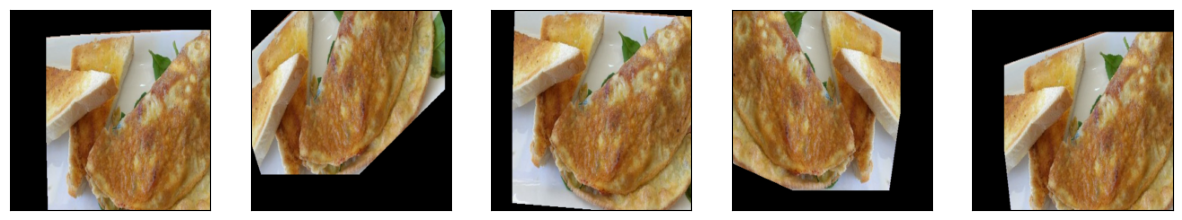

In [9]:
train_dataset = FoodDataset('./train/', tfm=train_tfm)
_, axes = plt.subplots(1, 5, figsize=(15, 50))
axes = axes.flatten()
for i in range(5):
    x,_ = train_dataset[0]
    x = x.permute(1,2,0)
    axes[i].imshow(x.data.numpy())
    axes[i].axes.get_xaxis().set_visible(False)
    axes[i].axes.get_yaxis().set_visible(False)
plt.show()

# Model

In [5]:
# class Classifier(nn.Module):
#     def __init__(self):
#         super(Classifier, self).__init__()
#         # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
#         # torch.nn.MaxPool2d(kernel_size, stride, padding)
#         # input 維度 [3, 128, 128]
#         self.cnn = nn.Sequential(
#             nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

#             nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

#             nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

#             nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]

#             nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
#         )
#         self.fc = nn.Sequential(
#             nn.Linear(512*4*4, 1024),
#             nn.ReLU(),
#             nn.Dropout(p=0.5),
#             nn.Linear(1024, 512),
#             nn.ReLU(),
#             nn.BatchNorm1d(512),
#             nn.Dropout(p=0.5),
#             nn.Linear(512, 11)
#         )

#     def forward(self, x):
#         out = self.cnn(x)
#         out = out.view(out.size()[0], -1)
#         return self.fc(out)
     
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.resnet = torchvision.models.resnet18(pretrained=False)
        self.resnet.fc = nn.Linear(512, 11)
    def forward(self, x):
        x = self.resnet(x)
        return x

# Configurations

In [6]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = Classifier().to(device)

# The number of batch size.
batch_size = 128

# The number of training epochs.
n_epochs = 200

# If no improvement in 'patience' epochs, early stop.
patience = 20
k_fold = 4

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

# Create a learning rate scheduler that reduces the learning rate when the metric stops improving
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.8, patience=patience/2, threshold=0.05)

C:\Users\Seo.Yi-jung\anaconda3\envs\ML\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Seo.Yi-jung\anaconda3\envs\ML\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
device

'cuda'

# Dataloader

In [8]:
# Construct train and valid datasets.
# The argument "loader" tells how torchvision reads the data.
train_dir = './train/'
valid_dir = './valid/'
train_files = [ os.path.join(train_dir, file) for file in os.listdir(train_dir) if file.endswith('.jpg')]
valid_files = [ os.path.join(valid_dir, file) for file in os.listdir(valid_dir) if file.endswith('.jpg')]
total_files = train_files + valid_files
random.shuffle(total_files)
nums = len(total_files) // k_fold

#train_set = FoodDataset("./train", tfm=train_tfm)
#train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
#valid_set = FoodDataset("./valid", tfm=test_tfm)
#valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

# Start Training

Cross Validation

In [15]:
# Create a SummaryWriter object to write data to TensorBoard and the results are stored in ./runs folder
#writer = SummaryWriter()

In [13]:
# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0

for i in range(k_fold):
    stale = 0
    best_acc = 0

    model = Classifier().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=80, T_mult=1, eta_min=3e-5)
    criterion = nn.CrossEntropyLoss()
    print(f'FOLD {i+1}', '-'*50)

    valid_files = total_files[i*nums:(i+1)*nums]
    train_files = total_files[:i*nums] + total_files[(i+1)*nums:]
    
    train_set = FoodDataset(tfm=train_tfm, files=train_files)
    train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=0, pin_memory=True)

    valid_set = FoodDataset(tfm=test_tfm, files=valid_files)
    valid_loader = DataLoader(valid_set, batch_size, shuffle=False, num_workers=0, pin_memory=True)

    for epoch in range(n_epochs):

        # ---------- Training ----------
        # Make sure the model is in train mode before training.
        model.train()

        # These are used to record information in training.
        train_loss = []
        train_accs = []

        for batch in tqdm(train_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch
            #imgs = imgs.half()
            #print(imgs.shape,labels.shape)

            # Forward the data. (Make sure data and model are on the same device.)
            logits = model(imgs.to(device))

            # Calculate the cross-entropy loss.
            # We don't need to apply softmax before computing cross-entropy as it is done automatically.
            loss = criterion(logits, labels.to(device))

            # Gradients stored in the parameters in the previous step should be cleared out first.
            optimizer.zero_grad()

            # Compute the gradients for parameters.
            loss.backward()

            # Clip the gradient norms for stable training.
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

            # Update the parameters with computed gradients.
            optimizer.step()

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            train_loss.append(loss.item())
            train_accs.append(acc)
            
        train_loss = sum(train_loss) / len(train_loss)
        train_acc = sum(train_accs) / len(train_accs)

        # Print the information.
        print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

        # ---------- Validation ----------
        # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
        model.eval()

        # These are used to record information in validation.
        valid_loss = []
        valid_accs = []

        # Iterate the validation set by batches.
        for batch in tqdm(valid_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch
            #imgs = imgs.half()

            # We don't need gradient in validation.
            # Using torch.no_grad() accelerates the forward process.
            with torch.no_grad():
                logits = model(imgs.to(device))

            # We can still compute the loss (but not the gradient).
            loss = criterion(logits, labels.to(device))

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            valid_loss.append(loss.item())
            valid_accs.append(acc)
            #break

        # The average loss and accuracy for entire validation set is the average of the recorded values.
        valid_loss = sum(valid_loss) / len(valid_loss)
        valid_acc = sum(valid_accs) / len(valid_accs)

        # Print the information.
        print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


        # update logs
        if valid_acc > best_acc:
            with open(f"./fold_{i+1}_{_exp_name}_log.txt","a") as f:
                f.write(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best\n")
        else:
            with open(f"./fold_{i+1}_{_exp_name}_log.txt","a") as f:
                f.write(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}\n")
        f.close()


        # save models
        if valid_acc > best_acc:
            print(f"Best model found at epoch {epoch+1}, saving model")
            torch.save(model.state_dict(), f"fold_{i+1}_{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
            best_acc = valid_acc
            stale = 0
        else:
            stale += 1
            if stale > patience:
                print(f"No improvment {patience} consecutive epochs, early stopping")
                break

FOLD 1 --------------------------------------------------
data length: 10233
data length: 3410


  0%|          | 0/80 [00:00<?, ?it/s]

C:\Users\Seo.Yi-jung\anaconda3\envs\ML\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


[ Train | 001/200 ] loss = 1.85967, acc = 0.35067


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 001/200 ] loss = 2.01388, acc = 0.34050
Best model found at epoch 1, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 002/200 ] loss = 1.61626, acc = 0.43431


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 002/200 ] loss = 1.86902, acc = 0.36940
Best model found at epoch 2, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 003/200 ] loss = 1.45771, acc = 0.50053


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 003/200 ] loss = 1.55814, acc = 0.48750
Best model found at epoch 3, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 004/200 ] loss = 1.36024, acc = 0.53034


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 004/200 ] loss = 1.59614, acc = 0.48452


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 005/200 ] loss = 1.28639, acc = 0.56315


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 005/200 ] loss = 2.18782, acc = 0.38703


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 006/200 ] loss = 1.20246, acc = 0.58508


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 006/200 ] loss = 2.01392, acc = 0.41115


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 007/200 ] loss = 1.14643, acc = 0.60617


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 007/200 ] loss = 1.91706, acc = 0.43374


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 008/200 ] loss = 1.10069, acc = 0.62027


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 008/200 ] loss = 1.67766, acc = 0.49656
Best model found at epoch 8, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 009/200 ] loss = 1.03968, acc = 0.64495


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 009/200 ] loss = 1.79466, acc = 0.45795


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 010/200 ] loss = 1.02230, acc = 0.64845


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 010/200 ] loss = 3.81842, acc = 0.29191


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 011/200 ] loss = 0.96586, acc = 0.67037


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 011/200 ] loss = 1.93657, acc = 0.47485


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 012/200 ] loss = 0.92317, acc = 0.68558


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 012/200 ] loss = 1.63480, acc = 0.52687
Best model found at epoch 12, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 013/200 ] loss = 0.90449, acc = 0.69011


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 013/200 ] loss = 1.70731, acc = 0.49430


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 014/200 ] loss = 0.87201, acc = 0.70222


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 014/200 ] loss = 1.57060, acc = 0.52400


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 015/200 ] loss = 0.82236, acc = 0.72541


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 015/200 ] loss = 1.51148, acc = 0.55720
Best model found at epoch 15, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 016/200 ] loss = 0.80706, acc = 0.72293


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 016/200 ] loss = 1.52626, acc = 0.52803


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 017/200 ] loss = 0.80208, acc = 0.72765


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 017/200 ] loss = 1.74149, acc = 0.53704


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 018/200 ] loss = 0.75124, acc = 0.74431


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 018/200 ] loss = 1.82045, acc = 0.53810


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 019/200 ] loss = 0.73174, acc = 0.74932


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 019/200 ] loss = 2.24123, acc = 0.45615


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 020/200 ] loss = 0.70653, acc = 0.75846


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 020/200 ] loss = 1.21260, acc = 0.63874
Best model found at epoch 20, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 021/200 ] loss = 0.70369, acc = 0.75762


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 021/200 ] loss = 1.39758, acc = 0.59749


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 022/200 ] loss = 0.67470, acc = 0.76446


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 022/200 ] loss = 1.40039, acc = 0.62035


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 023/200 ] loss = 0.65210, acc = 0.77446


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 023/200 ] loss = 1.34384, acc = 0.63254


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 024/200 ] loss = 0.64240, acc = 0.77902


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 024/200 ] loss = 1.01474, acc = 0.69337
Best model found at epoch 24, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 025/200 ] loss = 0.60249, acc = 0.78706


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 025/200 ] loss = 1.12868, acc = 0.68717


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 026/200 ] loss = 0.59790, acc = 0.79525


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 026/200 ] loss = 1.70640, acc = 0.56324


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 027/200 ] loss = 0.58833, acc = 0.79475


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 027/200 ] loss = 1.13262, acc = 0.66469


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 028/200 ] loss = 0.56117, acc = 0.80936


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 028/200 ] loss = 1.21954, acc = 0.67089


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 029/200 ] loss = 0.54780, acc = 0.80993


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 029/200 ] loss = 1.81717, acc = 0.55119


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 030/200 ] loss = 0.53095, acc = 0.82045


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 030/200 ] loss = 1.51545, acc = 0.60919


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 031/200 ] loss = 0.51232, acc = 0.81944


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 031/200 ] loss = 1.40493, acc = 0.60650


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 032/200 ] loss = 0.51286, acc = 0.82423


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 032/200 ] loss = 1.47176, acc = 0.60964


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 033/200 ] loss = 0.47624, acc = 0.83555


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 033/200 ] loss = 1.26297, acc = 0.65890


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 034/200 ] loss = 0.46425, acc = 0.84048


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 034/200 ] loss = 1.59688, acc = 0.60906


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 035/200 ] loss = 0.47358, acc = 0.83683


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 035/200 ] loss = 1.07708, acc = 0.69758
Best model found at epoch 35, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 036/200 ] loss = 0.43990, acc = 0.85014


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 036/200 ] loss = 1.70531, acc = 0.60364


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 037/200 ] loss = 0.42378, acc = 0.85619


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 037/200 ] loss = 1.32743, acc = 0.65733


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 038/200 ] loss = 0.40779, acc = 0.85531


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 038/200 ] loss = 1.20989, acc = 0.69655


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 039/200 ] loss = 0.40651, acc = 0.85733


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 039/200 ] loss = 1.02999, acc = 0.71363
Best model found at epoch 39, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 040/200 ] loss = 0.40614, acc = 0.85947


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 040/200 ] loss = 1.90232, acc = 0.56566


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 041/200 ] loss = 0.38201, acc = 0.87122


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 041/200 ] loss = 1.33350, acc = 0.69473


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 042/200 ] loss = 0.39259, acc = 0.86361


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 042/200 ] loss = 1.27287, acc = 0.68826


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 043/200 ] loss = 0.37277, acc = 0.87150


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 043/200 ] loss = 1.51836, acc = 0.66084


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 044/200 ] loss = 0.35080, acc = 0.87692


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 044/200 ] loss = 1.40668, acc = 0.66897


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 045/200 ] loss = 0.34625, acc = 0.87765


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 045/200 ] loss = 0.98445, acc = 0.73341
Best model found at epoch 45, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 046/200 ] loss = 0.35044, acc = 0.87610


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 046/200 ] loss = 1.37718, acc = 0.68035


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 047/200 ] loss = 0.31792, acc = 0.88974


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 047/200 ] loss = 1.39836, acc = 0.68102


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 048/200 ] loss = 0.31068, acc = 0.88840


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 048/200 ] loss = 2.00333, acc = 0.61456


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 049/200 ] loss = 0.32239, acc = 0.88554


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 049/200 ] loss = 1.37543, acc = 0.69334


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 050/200 ] loss = 0.31084, acc = 0.88963


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 050/200 ] loss = 1.62503, acc = 0.64948


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 051/200 ] loss = 0.29700, acc = 0.89719


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 051/200 ] loss = 1.38831, acc = 0.67697


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 052/200 ] loss = 0.29436, acc = 0.89866


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 052/200 ] loss = 1.17829, acc = 0.71164


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 053/200 ] loss = 0.27638, acc = 0.90487


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 053/200 ] loss = 1.45086, acc = 0.69234


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 054/200 ] loss = 0.26186, acc = 0.91089


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 054/200 ] loss = 1.62555, acc = 0.63945


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 055/200 ] loss = 0.24611, acc = 0.91595


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 055/200 ] loss = 1.51031, acc = 0.68446


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 056/200 ] loss = 0.24622, acc = 0.91348


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 056/200 ] loss = 1.39420, acc = 0.68691


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 057/200 ] loss = 0.26644, acc = 0.90998


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 057/200 ] loss = 1.45258, acc = 0.69874


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 058/200 ] loss = 0.24204, acc = 0.91490


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 058/200 ] loss = 1.51899, acc = 0.70833


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 059/200 ] loss = 0.23357, acc = 0.92054


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 059/200 ] loss = 1.79294, acc = 0.64187


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 060/200 ] loss = 0.24140, acc = 0.91751


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 060/200 ] loss = 1.71128, acc = 0.67187


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 061/200 ] loss = 0.22880, acc = 0.92061


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 061/200 ] loss = 1.40444, acc = 0.68878


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 062/200 ] loss = 0.24267, acc = 0.91488


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 062/200 ] loss = 1.64603, acc = 0.67440


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 063/200 ] loss = 0.22399, acc = 0.92358


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 063/200 ] loss = 1.28899, acc = 0.71084


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 064/200 ] loss = 0.19215, acc = 0.93423


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 064/200 ] loss = 1.42305, acc = 0.69160


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 065/200 ] loss = 0.22060, acc = 0.92326


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 065/200 ] loss = 1.49500, acc = 0.70430


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 066/200 ] loss = 0.20086, acc = 0.93088


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 066/200 ] loss = 1.64236, acc = 0.68026
No improvment 20 consecutive epochs, early stopping
FOLD 2 --------------------------------------------------
data length: 10233
data length: 3410


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 001/200 ] loss = 1.86882, acc = 0.34532


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 001/200 ] loss = 1.88062, acc = 0.39844
Best model found at epoch 1, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 002/200 ] loss = 1.59179, acc = 0.44860


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 002/200 ] loss = 2.81315, acc = 0.27556


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 003/200 ] loss = 1.46168, acc = 0.49279


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 003/200 ] loss = 1.83433, acc = 0.40492
Best model found at epoch 3, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 004/200 ] loss = 1.35866, acc = 0.53581


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 004/200 ] loss = 1.57228, acc = 0.49562
Best model found at epoch 4, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 005/200 ] loss = 1.26596, acc = 0.56776


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 005/200 ] loss = 2.44001, acc = 0.29632


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 006/200 ] loss = 1.22243, acc = 0.57666


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 006/200 ] loss = 1.67692, acc = 0.46969


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 007/200 ] loss = 1.13954, acc = 0.60836


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 007/200 ] loss = 1.63130, acc = 0.49807
Best model found at epoch 7, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 008/200 ] loss = 1.09134, acc = 0.62608


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 008/200 ] loss = 1.86916, acc = 0.47260


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 009/200 ] loss = 1.04812, acc = 0.63631


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 009/200 ] loss = 1.80530, acc = 0.48768


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 010/200 ] loss = 1.00935, acc = 0.65242


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 010/200 ] loss = 2.15797, acc = 0.46711


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 011/200 ] loss = 0.97536, acc = 0.66445


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 011/200 ] loss = 1.56244, acc = 0.52926
Best model found at epoch 11, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 012/200 ] loss = 0.91431, acc = 0.68610


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 012/200 ] loss = 1.97420, acc = 0.52356


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 013/200 ] loss = 0.90459, acc = 0.69348


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 013/200 ] loss = 1.36047, acc = 0.57232
Best model found at epoch 13, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 014/200 ] loss = 0.86305, acc = 0.70471


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 014/200 ] loss = 1.26256, acc = 0.60254
Best model found at epoch 14, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 015/200 ] loss = 0.85454, acc = 0.71075


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 015/200 ] loss = 1.43149, acc = 0.58597


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 016/200 ] loss = 0.82240, acc = 0.71628


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 016/200 ] loss = 2.88453, acc = 0.37113


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 017/200 ] loss = 0.77572, acc = 0.73445


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 017/200 ] loss = 2.84235, acc = 0.46183


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 018/200 ] loss = 0.74807, acc = 0.74005


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 018/200 ] loss = 1.92533, acc = 0.48459


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 019/200 ] loss = 0.74543, acc = 0.74613


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 019/200 ] loss = 1.28332, acc = 0.62333
Best model found at epoch 19, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 020/200 ] loss = 0.69949, acc = 0.75930


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 020/200 ] loss = 1.53774, acc = 0.57906


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 021/200 ] loss = 0.67887, acc = 0.76694


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 021/200 ] loss = 1.84043, acc = 0.51315


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 022/200 ] loss = 0.66315, acc = 0.77238


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 022/200 ] loss = 1.21513, acc = 0.63639
Best model found at epoch 22, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 023/200 ] loss = 0.65063, acc = 0.77584


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 023/200 ] loss = 2.24364, acc = 0.46967


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 024/200 ] loss = 0.63990, acc = 0.77858


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 024/200 ] loss = 1.38921, acc = 0.62273


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 025/200 ] loss = 0.61297, acc = 0.78978


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 025/200 ] loss = 2.09273, acc = 0.51957


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 026/200 ] loss = 0.59837, acc = 0.79438


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 026/200 ] loss = 1.39658, acc = 0.61894


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 027/200 ] loss = 0.58723, acc = 0.80182


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 027/200 ] loss = 1.47893, acc = 0.61122


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 028/200 ] loss = 0.57521, acc = 0.80006


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 028/200 ] loss = 1.53044, acc = 0.60033


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 029/200 ] loss = 0.55189, acc = 0.81083


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 029/200 ] loss = 1.27931, acc = 0.64565
Best model found at epoch 29, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 030/200 ] loss = 0.53018, acc = 0.81432


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 030/200 ] loss = 1.81001, acc = 0.55485


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 031/200 ] loss = 0.53200, acc = 0.81922


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 031/200 ] loss = 1.35991, acc = 0.64337


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 032/200 ] loss = 0.50983, acc = 0.82184


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 032/200 ] loss = 1.31741, acc = 0.64785
Best model found at epoch 32, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 033/200 ] loss = 0.48391, acc = 0.83347


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 033/200 ] loss = 1.24611, acc = 0.66650
Best model found at epoch 33, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 034/200 ] loss = 0.48442, acc = 0.82868


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 034/200 ] loss = 1.10641, acc = 0.69373
Best model found at epoch 34, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 035/200 ] loss = 0.45904, acc = 0.84098


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 035/200 ] loss = 1.59081, acc = 0.63212


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 036/200 ] loss = 0.46956, acc = 0.83715


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 036/200 ] loss = 1.43852, acc = 0.64276


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 037/200 ] loss = 0.44597, acc = 0.84383


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 037/200 ] loss = 1.54368, acc = 0.63697


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 038/200 ] loss = 0.43304, acc = 0.85030


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 038/200 ] loss = 1.30517, acc = 0.67015


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 039/200 ] loss = 0.42714, acc = 0.85332


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 039/200 ] loss = 1.82807, acc = 0.58315


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 040/200 ] loss = 0.38735, acc = 0.86349


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 040/200 ] loss = 1.22167, acc = 0.70219
Best model found at epoch 40, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 041/200 ] loss = 0.38837, acc = 0.86315


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 041/200 ] loss = 1.76343, acc = 0.60420


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 042/200 ] loss = 0.38013, acc = 0.86927


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 042/200 ] loss = 1.34056, acc = 0.66890


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 043/200 ] loss = 0.36443, acc = 0.86884


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 043/200 ] loss = 1.32504, acc = 0.67697


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 044/200 ] loss = 0.35512, acc = 0.87940


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 044/200 ] loss = 1.51260, acc = 0.64990


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 045/200 ] loss = 0.33630, acc = 0.88135


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 045/200 ] loss = 1.58899, acc = 0.63704


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 046/200 ] loss = 0.34343, acc = 0.87940


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 046/200 ] loss = 1.41794, acc = 0.66225


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 047/200 ] loss = 0.34625, acc = 0.87805


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 047/200 ] loss = 1.30244, acc = 0.69312


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 048/200 ] loss = 0.31761, acc = 0.88867


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 048/200 ] loss = 1.49948, acc = 0.65051


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 049/200 ] loss = 0.31800, acc = 0.88963


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 049/200 ] loss = 1.44067, acc = 0.66954


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 050/200 ] loss = 0.29077, acc = 0.89934


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 050/200 ] loss = 1.66274, acc = 0.65341


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 051/200 ] loss = 0.28511, acc = 0.90004


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 051/200 ] loss = 1.32638, acc = 0.69154


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 052/200 ] loss = 0.28264, acc = 0.90244


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 052/200 ] loss = 1.48229, acc = 0.66015


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 053/200 ] loss = 0.29322, acc = 0.89633


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 053/200 ] loss = 1.31385, acc = 0.71164
Best model found at epoch 53, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 054/200 ] loss = 0.28218, acc = 0.90082


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 054/200 ] loss = 1.21305, acc = 0.70713


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 055/200 ] loss = 0.25552, acc = 0.91272


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 055/200 ] loss = 2.03305, acc = 0.63324


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 056/200 ] loss = 0.26361, acc = 0.90756


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 056/200 ] loss = 1.39951, acc = 0.69363


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 057/200 ] loss = 0.22710, acc = 0.92347


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 057/200 ] loss = 1.59193, acc = 0.66858


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 058/200 ] loss = 0.24380, acc = 0.91399


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 058/200 ] loss = 1.70165, acc = 0.65077


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 059/200 ] loss = 0.23603, acc = 0.91872


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 059/200 ] loss = 1.57055, acc = 0.69113


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 060/200 ] loss = 0.22372, acc = 0.92281


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 060/200 ] loss = 2.00774, acc = 0.62720


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 061/200 ] loss = 0.23351, acc = 0.91772


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 061/200 ] loss = 1.39319, acc = 0.70131


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 062/200 ] loss = 0.20831, acc = 0.92667


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 062/200 ] loss = 1.74068, acc = 0.66100


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 063/200 ] loss = 0.22618, acc = 0.92299


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 063/200 ] loss = 1.29895, acc = 0.71784
Best model found at epoch 63, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 064/200 ] loss = 0.22088, acc = 0.92395


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 064/200 ] loss = 2.07229, acc = 0.63102


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 065/200 ] loss = 0.21514, acc = 0.92525


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 065/200 ] loss = 1.34383, acc = 0.71912
Best model found at epoch 65, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 066/200 ] loss = 0.22368, acc = 0.92296


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 066/200 ] loss = 1.51879, acc = 0.68941


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 067/200 ] loss = 0.20669, acc = 0.92867


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 067/200 ] loss = 1.36559, acc = 0.70806


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 068/200 ] loss = 0.20217, acc = 0.92758


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 068/200 ] loss = 2.40385, acc = 0.60733


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 069/200 ] loss = 0.19793, acc = 0.93130


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 069/200 ] loss = 1.48201, acc = 0.69919


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 070/200 ] loss = 0.18924, acc = 0.93443


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 070/200 ] loss = 1.50757, acc = 0.68929


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 071/200 ] loss = 0.17360, acc = 0.94076


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 071/200 ] loss = 1.59283, acc = 0.71330


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 072/200 ] loss = 0.19192, acc = 0.93307


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 072/200 ] loss = 1.47507, acc = 0.70887


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 073/200 ] loss = 0.16902, acc = 0.94122


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 073/200 ] loss = 1.82598, acc = 0.67053


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 074/200 ] loss = 0.18285, acc = 0.93540


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 074/200 ] loss = 1.51942, acc = 0.71106


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 075/200 ] loss = 0.17727, acc = 0.94029


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 075/200 ] loss = 1.70763, acc = 0.68717


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 076/200 ] loss = 0.14871, acc = 0.94760


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 076/200 ] loss = 1.48774, acc = 0.71681


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 077/200 ] loss = 0.16584, acc = 0.94558


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 077/200 ] loss = 1.36839, acc = 0.73370
Best model found at epoch 77, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 078/200 ] loss = 0.15881, acc = 0.94674


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 078/200 ] loss = 1.47772, acc = 0.73050


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 079/200 ] loss = 0.17180, acc = 0.94205


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 079/200 ] loss = 1.35613, acc = 0.74486
Best model found at epoch 79, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 080/200 ] loss = 0.16034, acc = 0.94627


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 080/200 ] loss = 1.78949, acc = 0.68932


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 081/200 ] loss = 0.16717, acc = 0.94262


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 081/200 ] loss = 1.83677, acc = 0.68420


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 082/200 ] loss = 0.14508, acc = 0.94800


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 082/200 ] loss = 1.31632, acc = 0.73987


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 083/200 ] loss = 0.13333, acc = 0.95329


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 083/200 ] loss = 1.44357, acc = 0.73093


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 084/200 ] loss = 0.13254, acc = 0.95553


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 084/200 ] loss = 1.48371, acc = 0.70958


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 085/200 ] loss = 0.14397, acc = 0.94841


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 085/200 ] loss = 1.44239, acc = 0.73999


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 086/200 ] loss = 0.16494, acc = 0.94546


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 086/200 ] loss = 1.67810, acc = 0.72186


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 087/200 ] loss = 0.13165, acc = 0.95395


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 087/200 ] loss = 1.53175, acc = 0.71999


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 088/200 ] loss = 0.12382, acc = 0.95887


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 088/200 ] loss = 1.67515, acc = 0.71386


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 089/200 ] loss = 0.12657, acc = 0.95553


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 089/200 ] loss = 1.44805, acc = 0.73305


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 090/200 ] loss = 0.14423, acc = 0.94978


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 090/200 ] loss = 1.29274, acc = 0.74862
Best model found at epoch 90, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 091/200 ] loss = 0.16564, acc = 0.94655


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 091/200 ] loss = 1.36726, acc = 0.72983


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 092/200 ] loss = 0.13081, acc = 0.95603


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 092/200 ] loss = 1.82561, acc = 0.66189


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 093/200 ] loss = 0.12497, acc = 0.95876


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 093/200 ] loss = 1.70899, acc = 0.69965


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 094/200 ] loss = 0.11927, acc = 0.95847


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 094/200 ] loss = 1.58761, acc = 0.71994


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 095/200 ] loss = 0.11510, acc = 0.96054


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 095/200 ] loss = 2.21841, acc = 0.66878


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 096/200 ] loss = 0.11816, acc = 0.96076


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 096/200 ] loss = 1.43921, acc = 0.73614


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 097/200 ] loss = 0.13703, acc = 0.95553


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 097/200 ] loss = 2.38143, acc = 0.63674


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 098/200 ] loss = 0.11881, acc = 0.95867


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 098/200 ] loss = 1.48776, acc = 0.73157


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 099/200 ] loss = 0.10136, acc = 0.96588


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 099/200 ] loss = 1.57677, acc = 0.72936


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 100/200 ] loss = 0.14278, acc = 0.95169


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 100/200 ] loss = 2.00422, acc = 0.65851


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 101/200 ] loss = 0.13558, acc = 0.95114


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 101/200 ] loss = 1.46135, acc = 0.73627


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 102/200 ] loss = 0.12602, acc = 0.95786


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 102/200 ] loss = 1.57372, acc = 0.72442


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 103/200 ] loss = 0.10306, acc = 0.96452


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 103/200 ] loss = 1.54105, acc = 0.73035


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 104/200 ] loss = 0.12564, acc = 0.95534


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 104/200 ] loss = 1.53646, acc = 0.72531


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 105/200 ] loss = 0.12228, acc = 0.95593


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 105/200 ] loss = 1.36829, acc = 0.74829


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 106/200 ] loss = 0.11300, acc = 0.96306


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 106/200 ] loss = 1.64234, acc = 0.71198


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 107/200 ] loss = 0.09077, acc = 0.96961


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 107/200 ] loss = 2.04164, acc = 0.67500


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 108/200 ] loss = 0.09423, acc = 0.96718


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 108/200 ] loss = 1.58611, acc = 0.72797


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 109/200 ] loss = 0.10586, acc = 0.96371


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 109/200 ] loss = 1.63912, acc = 0.71520


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 110/200 ] loss = 0.10857, acc = 0.96137


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 110/200 ] loss = 1.33398, acc = 0.75591
Best model found at epoch 110, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 111/200 ] loss = 0.10231, acc = 0.96628


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 111/200 ] loss = 1.77293, acc = 0.70712


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 112/200 ] loss = 0.10392, acc = 0.96523


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 112/200 ] loss = 2.12318, acc = 0.67231


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 113/200 ] loss = 0.12663, acc = 0.95600


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 113/200 ] loss = 1.48064, acc = 0.73681


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 114/200 ] loss = 0.09542, acc = 0.96580


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 114/200 ] loss = 1.52886, acc = 0.74375


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 115/200 ] loss = 0.10751, acc = 0.96275


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 115/200 ] loss = 1.44171, acc = 0.73282


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 116/200 ] loss = 0.09978, acc = 0.96464


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 116/200 ] loss = 1.65898, acc = 0.70742


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 117/200 ] loss = 0.09941, acc = 0.96579


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 117/200 ] loss = 1.82933, acc = 0.67543


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 118/200 ] loss = 0.10198, acc = 0.96590


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 118/200 ] loss = 1.43694, acc = 0.74296


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 119/200 ] loss = 0.10158, acc = 0.96590


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 119/200 ] loss = 1.71115, acc = 0.71681


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 120/200 ] loss = 0.10415, acc = 0.96596


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 120/200 ] loss = 1.92372, acc = 0.70044


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 121/200 ] loss = 0.11858, acc = 0.96074


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 121/200 ] loss = 1.46629, acc = 0.74354


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 122/200 ] loss = 0.09237, acc = 0.96796


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 122/200 ] loss = 1.52410, acc = 0.74370


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 123/200 ] loss = 0.08707, acc = 0.97068


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 123/200 ] loss = 2.00366, acc = 0.67536


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 124/200 ] loss = 0.09507, acc = 0.96745


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 124/200 ] loss = 1.93779, acc = 0.69585


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 125/200 ] loss = 0.09301, acc = 0.96715


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 125/200 ] loss = 1.40155, acc = 0.75354


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 126/200 ] loss = 0.08905, acc = 0.96765


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 126/200 ] loss = 1.36280, acc = 0.75350


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 127/200 ] loss = 0.09216, acc = 0.97010


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 127/200 ] loss = 1.98283, acc = 0.70820


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 128/200 ] loss = 0.08427, acc = 0.97158


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 128/200 ] loss = 1.61639, acc = 0.72903


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 129/200 ] loss = 0.09386, acc = 0.96703


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 129/200 ] loss = 2.04601, acc = 0.68032


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 130/200 ] loss = 0.09072, acc = 0.96952


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 130/200 ] loss = 1.35437, acc = 0.75867
Best model found at epoch 130, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 131/200 ] loss = 0.07622, acc = 0.97516


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 131/200 ] loss = 1.91069, acc = 0.70717


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 132/200 ] loss = 0.09350, acc = 0.96824


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 132/200 ] loss = 1.53915, acc = 0.75090


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 133/200 ] loss = 0.07835, acc = 0.97205


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 133/200 ] loss = 1.35217, acc = 0.75804


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 134/200 ] loss = 0.07127, acc = 0.97587


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 134/200 ] loss = 1.64533, acc = 0.72816


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 135/200 ] loss = 0.09828, acc = 0.96353


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 135/200 ] loss = 1.84142, acc = 0.70270


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 136/200 ] loss = 0.11616, acc = 0.95994


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 136/200 ] loss = 1.42286, acc = 0.75041


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 137/200 ] loss = 0.07812, acc = 0.97381


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 137/200 ] loss = 1.35022, acc = 0.76505
Best model found at epoch 137, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 138/200 ] loss = 0.07197, acc = 0.97567


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 138/200 ] loss = 1.52897, acc = 0.73936


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 139/200 ] loss = 0.07551, acc = 0.97615


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 139/200 ] loss = 1.94116, acc = 0.70240


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 140/200 ] loss = 0.10554, acc = 0.96410


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 140/200 ] loss = 2.27034, acc = 0.67737


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 141/200 ] loss = 0.10660, acc = 0.96353


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 141/200 ] loss = 1.72310, acc = 0.72222


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 142/200 ] loss = 0.08880, acc = 0.96795


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 142/200 ] loss = 1.49173, acc = 0.73685


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 143/200 ] loss = 0.06262, acc = 0.98055


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 143/200 ] loss = 1.46339, acc = 0.75350


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 144/200 ] loss = 0.08296, acc = 0.97332


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 144/200 ] loss = 1.64691, acc = 0.74752


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 145/200 ] loss = 0.09706, acc = 0.96785


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 145/200 ] loss = 2.40639, acc = 0.67569


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 146/200 ] loss = 0.08758, acc = 0.97020


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 146/200 ] loss = 1.70882, acc = 0.71241


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 147/200 ] loss = 0.07179, acc = 0.97694


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 147/200 ] loss = 1.51328, acc = 0.74093


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 148/200 ] loss = 0.08176, acc = 0.97332


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 148/200 ] loss = 1.73753, acc = 0.72659


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 149/200 ] loss = 0.09238, acc = 0.96854


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 149/200 ] loss = 1.95668, acc = 0.69668


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 150/200 ] loss = 0.09132, acc = 0.96912


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 150/200 ] loss = 1.60115, acc = 0.73800


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 151/200 ] loss = 0.08480, acc = 0.97185


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 151/200 ] loss = 1.73814, acc = 0.71880


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 152/200 ] loss = 0.08406, acc = 0.97244


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 152/200 ] loss = 1.24481, acc = 0.77547
Best model found at epoch 152, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 153/200 ] loss = 0.06554, acc = 0.97929


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 153/200 ] loss = 1.45042, acc = 0.75289


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 154/200 ] loss = 0.06590, acc = 0.97587


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 154/200 ] loss = 1.54592, acc = 0.75354


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 155/200 ] loss = 0.08109, acc = 0.97339


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 155/200 ] loss = 1.70990, acc = 0.72757


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 156/200 ] loss = 0.08659, acc = 0.96999


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 156/200 ] loss = 1.50126, acc = 0.74318


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 157/200 ] loss = 0.08669, acc = 0.97126


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 157/200 ] loss = 1.49661, acc = 0.76486


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 158/200 ] loss = 0.06695, acc = 0.97703


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 158/200 ] loss = 1.53601, acc = 0.74131


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 159/200 ] loss = 0.06926, acc = 0.97760


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 159/200 ] loss = 1.44126, acc = 0.75983


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 160/200 ] loss = 0.07653, acc = 0.97487


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 160/200 ] loss = 1.40951, acc = 0.75697


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 161/200 ] loss = 0.05950, acc = 0.97908


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 161/200 ] loss = 1.76455, acc = 0.73502


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 162/200 ] loss = 0.07124, acc = 0.97684


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 162/200 ] loss = 1.57499, acc = 0.72735


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 163/200 ] loss = 0.08666, acc = 0.97088


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 163/200 ] loss = 2.34812, acc = 0.68614


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 164/200 ] loss = 0.08024, acc = 0.97352


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 164/200 ] loss = 1.46443, acc = 0.75079


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 165/200 ] loss = 0.06277, acc = 0.97927


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 165/200 ] loss = 1.50804, acc = 0.76967


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 166/200 ] loss = 0.04286, acc = 0.98641


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 166/200 ] loss = 1.73746, acc = 0.73809


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 167/200 ] loss = 0.05373, acc = 0.98222


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 167/200 ] loss = 1.37543, acc = 0.77603
Best model found at epoch 167, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 168/200 ] loss = 0.07479, acc = 0.97499


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 168/200 ] loss = 1.75522, acc = 0.73269


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 169/200 ] loss = 0.06670, acc = 0.97968


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 169/200 ] loss = 1.54532, acc = 0.73941


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 170/200 ] loss = 0.07620, acc = 0.97398


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 170/200 ] loss = 1.34915, acc = 0.76697


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 171/200 ] loss = 0.07783, acc = 0.97294


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 171/200 ] loss = 1.37723, acc = 0.75356


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 172/200 ] loss = 0.05447, acc = 0.98262


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 172/200 ] loss = 1.37833, acc = 0.76710


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 173/200 ] loss = 0.05917, acc = 0.97976


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 173/200 ] loss = 1.58220, acc = 0.74106


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 174/200 ] loss = 0.07519, acc = 0.97324


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 174/200 ] loss = 1.71174, acc = 0.73482


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 175/200 ] loss = 0.07205, acc = 0.97597


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 175/200 ] loss = 1.63528, acc = 0.74354


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 176/200 ] loss = 0.07899, acc = 0.97391


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 176/200 ] loss = 1.74294, acc = 0.72440


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 177/200 ] loss = 0.06545, acc = 0.97773


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 177/200 ] loss = 1.38418, acc = 0.75591


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 178/200 ] loss = 0.05732, acc = 0.98095


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 178/200 ] loss = 1.46819, acc = 0.75665


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 179/200 ] loss = 0.08230, acc = 0.97117


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 179/200 ] loss = 2.09556, acc = 0.68777


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 180/200 ] loss = 0.07010, acc = 0.97655


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 180/200 ] loss = 1.99766, acc = 0.71144


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 181/200 ] loss = 0.06028, acc = 0.98132


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 181/200 ] loss = 1.51805, acc = 0.75672


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 182/200 ] loss = 0.07242, acc = 0.97644


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 182/200 ] loss = 1.71792, acc = 0.72234


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 183/200 ] loss = 0.05703, acc = 0.98085


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 183/200 ] loss = 1.59103, acc = 0.75507


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 184/200 ] loss = 0.08275, acc = 0.97133


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 184/200 ] loss = 1.48184, acc = 0.74778


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 185/200 ] loss = 0.07667, acc = 0.97410


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 185/200 ] loss = 1.61580, acc = 0.73482


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 186/200 ] loss = 0.06527, acc = 0.97860


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 186/200 ] loss = 1.65431, acc = 0.74140


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 187/200 ] loss = 0.07099, acc = 0.97695


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 187/200 ] loss = 1.43310, acc = 0.75039


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 188/200 ] loss = 0.05572, acc = 0.98123


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 188/200 ] loss = 1.46679, acc = 0.75241
No improvment 20 consecutive epochs, early stopping
FOLD 3 --------------------------------------------------
data length: 10233
data length: 3410


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 001/200 ] loss = 1.84285, acc = 0.35622


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 001/200 ] loss = 2.20627, acc = 0.28688
Best model found at epoch 1, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 002/200 ] loss = 1.60264, acc = 0.43986


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 002/200 ] loss = 1.66107, acc = 0.44356
Best model found at epoch 2, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 003/200 ] loss = 1.46545, acc = 0.49508


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 003/200 ] loss = 2.42368, acc = 0.32858


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 004/200 ] loss = 1.36645, acc = 0.52990


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 004/200 ] loss = 1.78887, acc = 0.46132
Best model found at epoch 4, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 005/200 ] loss = 1.26648, acc = 0.56099


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 005/200 ] loss = 1.87598, acc = 0.44823


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 006/200 ] loss = 1.20761, acc = 0.58173


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 006/200 ] loss = 1.88337, acc = 0.44751


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 007/200 ] loss = 1.14202, acc = 0.60382


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 007/200 ] loss = 1.41401, acc = 0.54968
Best model found at epoch 7, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 008/200 ] loss = 1.09493, acc = 0.62263


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 008/200 ] loss = 1.97411, acc = 0.47984


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 009/200 ] loss = 1.04583, acc = 0.64146


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 009/200 ] loss = 1.48799, acc = 0.53534


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 010/200 ] loss = 1.00395, acc = 0.65152


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 010/200 ] loss = 1.34347, acc = 0.55467
Best model found at epoch 10, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 011/200 ] loss = 0.94749, acc = 0.67714


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 011/200 ] loss = 1.54542, acc = 0.54357


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 012/200 ] loss = 0.93851, acc = 0.67916


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 012/200 ] loss = 1.92428, acc = 0.47665


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 013/200 ] loss = 0.87781, acc = 0.69785


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 013/200 ] loss = 1.34037, acc = 0.60279
Best model found at epoch 13, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 014/200 ] loss = 0.85928, acc = 0.70713


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 014/200 ] loss = 1.80886, acc = 0.51112


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 015/200 ] loss = 0.85942, acc = 0.70616


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 015/200 ] loss = 1.77106, acc = 0.50559


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 016/200 ] loss = 0.80722, acc = 0.72137


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 016/200 ] loss = 1.33894, acc = 0.61109
Best model found at epoch 16, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 017/200 ] loss = 0.79133, acc = 0.72589


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 017/200 ] loss = 1.59232, acc = 0.57247


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 018/200 ] loss = 0.77737, acc = 0.73087


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 018/200 ] loss = 1.84171, acc = 0.50335


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 019/200 ] loss = 0.72093, acc = 0.74924


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 019/200 ] loss = 1.57458, acc = 0.57252


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 020/200 ] loss = 0.71391, acc = 0.75117


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 020/200 ] loss = 1.87681, acc = 0.53512


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 021/200 ] loss = 0.71373, acc = 0.75185


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 021/200 ] loss = 1.34246, acc = 0.62628
Best model found at epoch 21, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 022/200 ] loss = 0.66326, acc = 0.77162


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 022/200 ] loss = 1.21974, acc = 0.66840
Best model found at epoch 22, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 023/200 ] loss = 0.65685, acc = 0.77295


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 023/200 ] loss = 1.26296, acc = 0.63540


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 024/200 ] loss = 0.62746, acc = 0.78407


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 024/200 ] loss = 1.31483, acc = 0.64967


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 025/200 ] loss = 0.62008, acc = 0.78511


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 025/200 ] loss = 1.21640, acc = 0.65710


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 026/200 ] loss = 0.58937, acc = 0.79606


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 026/200 ] loss = 1.10746, acc = 0.70073
Best model found at epoch 26, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 027/200 ] loss = 0.59020, acc = 0.79701


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 027/200 ] loss = 1.60684, acc = 0.57675


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 028/200 ] loss = 0.57722, acc = 0.79879


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 028/200 ] loss = 1.32807, acc = 0.62579


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 029/200 ] loss = 0.55421, acc = 0.81010


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 029/200 ] loss = 1.46697, acc = 0.63974


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 030/200 ] loss = 0.53298, acc = 0.81826


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 030/200 ] loss = 1.09237, acc = 0.69549


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 031/200 ] loss = 0.54685, acc = 0.81111


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 031/200 ] loss = 1.20251, acc = 0.67746


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 032/200 ] loss = 0.50496, acc = 0.82683


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 032/200 ] loss = 1.65702, acc = 0.63681


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 033/200 ] loss = 0.49778, acc = 0.82829


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 033/200 ] loss = 1.77352, acc = 0.60664


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 034/200 ] loss = 0.47565, acc = 0.83407


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 034/200 ] loss = 1.14490, acc = 0.70607
Best model found at epoch 34, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 035/200 ] loss = 0.46651, acc = 0.83963


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 035/200 ] loss = 2.07811, acc = 0.56268


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 036/200 ] loss = 0.45975, acc = 0.84087


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 036/200 ] loss = 1.17580, acc = 0.69961


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 037/200 ] loss = 0.45173, acc = 0.84314


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 037/200 ] loss = 1.07122, acc = 0.71748
Best model found at epoch 37, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 038/200 ] loss = 0.44353, acc = 0.84593


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 038/200 ] loss = 1.42338, acc = 0.65372


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 039/200 ] loss = 0.43804, acc = 0.84969


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 039/200 ] loss = 1.44602, acc = 0.65581


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 040/200 ] loss = 0.42421, acc = 0.85133


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 040/200 ] loss = 1.89047, acc = 0.59789


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 041/200 ] loss = 0.38668, acc = 0.86331


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 041/200 ] loss = 1.31526, acc = 0.69059


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 042/200 ] loss = 0.39937, acc = 0.86200


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 042/200 ] loss = 1.37423, acc = 0.69041


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 043/200 ] loss = 0.37011, acc = 0.87351


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 043/200 ] loss = 1.50709, acc = 0.66565


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 044/200 ] loss = 0.36219, acc = 0.87370


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 044/200 ] loss = 1.24021, acc = 0.68871


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 045/200 ] loss = 0.36212, acc = 0.87783


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 045/200 ] loss = 1.30804, acc = 0.68558


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 046/200 ] loss = 0.36634, acc = 0.87401


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 046/200 ] loss = 1.17796, acc = 0.70742


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 047/200 ] loss = 0.34173, acc = 0.88245


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 047/200 ] loss = 2.15255, acc = 0.57693


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 048/200 ] loss = 0.30977, acc = 0.89282


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 048/200 ] loss = 1.30321, acc = 0.69912


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 049/200 ] loss = 0.32019, acc = 0.88720


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 049/200 ] loss = 1.63153, acc = 0.64822


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 050/200 ] loss = 0.32232, acc = 0.88471


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 050/200 ] loss = 1.47520, acc = 0.68323


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 051/200 ] loss = 0.30333, acc = 0.89497


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 051/200 ] loss = 1.08653, acc = 0.72536
Best model found at epoch 51, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 052/200 ] loss = 0.28754, acc = 0.90157


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 052/200 ] loss = 1.57974, acc = 0.69111


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 053/200 ] loss = 0.30333, acc = 0.89321


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 053/200 ] loss = 2.12459, acc = 0.59961


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 054/200 ] loss = 0.30508, acc = 0.89342


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 054/200 ] loss = 1.17904, acc = 0.72455


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 055/200 ] loss = 0.27508, acc = 0.90266


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 055/200 ] loss = 1.41343, acc = 0.71314


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 056/200 ] loss = 0.26285, acc = 0.90734


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 056/200 ] loss = 1.40636, acc = 0.68540


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 057/200 ] loss = 0.26755, acc = 0.90709


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 057/200 ] loss = 1.28553, acc = 0.72838
Best model found at epoch 57, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 058/200 ] loss = 0.26351, acc = 0.91077


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 058/200 ] loss = 1.29507, acc = 0.72243


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 059/200 ] loss = 0.25524, acc = 0.91243


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 059/200 ] loss = 1.81560, acc = 0.66545


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 060/200 ] loss = 0.24282, acc = 0.91641


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 060/200 ] loss = 1.33682, acc = 0.72043


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 061/200 ] loss = 0.21553, acc = 0.92672


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 061/200 ] loss = 1.53908, acc = 0.68603


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 062/200 ] loss = 0.23840, acc = 0.91519


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 062/200 ] loss = 1.55124, acc = 0.68728


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 063/200 ] loss = 0.25228, acc = 0.91048


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 063/200 ] loss = 2.55424, acc = 0.55409


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 064/200 ] loss = 0.22745, acc = 0.91947


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 064/200 ] loss = 1.27145, acc = 0.71739


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 065/200 ] loss = 0.18845, acc = 0.93658


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 065/200 ] loss = 1.28837, acc = 0.73379
Best model found at epoch 65, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 066/200 ] loss = 0.20594, acc = 0.92812


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 066/200 ] loss = 1.52292, acc = 0.70569


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 067/200 ] loss = 0.21373, acc = 0.92465


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 067/200 ] loss = 2.03429, acc = 0.62124


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 068/200 ] loss = 0.22156, acc = 0.92250


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 068/200 ] loss = 1.69351, acc = 0.67871


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 069/200 ] loss = 0.20469, acc = 0.92759


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 069/200 ] loss = 1.18925, acc = 0.74922
Best model found at epoch 69, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 070/200 ] loss = 0.19201, acc = 0.93316


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 070/200 ] loss = 1.18042, acc = 0.76070
Best model found at epoch 70, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 071/200 ] loss = 0.18765, acc = 0.93444


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 071/200 ] loss = 1.32260, acc = 0.72202


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 072/200 ] loss = 0.19823, acc = 0.93211


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 072/200 ] loss = 1.25901, acc = 0.73925


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 073/200 ] loss = 0.19981, acc = 0.93209


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 073/200 ] loss = 1.32690, acc = 0.72842


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 074/200 ] loss = 0.18528, acc = 0.93590


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 074/200 ] loss = 1.33749, acc = 0.73710


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 075/200 ] loss = 0.17610, acc = 0.93969


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 075/200 ] loss = 1.67414, acc = 0.70308


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 076/200 ] loss = 0.19728, acc = 0.93024


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 076/200 ] loss = 1.18730, acc = 0.76533
Best model found at epoch 76, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 077/200 ] loss = 0.16746, acc = 0.94294


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 077/200 ] loss = 1.37660, acc = 0.74292


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 078/200 ] loss = 0.16807, acc = 0.94059


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 078/200 ] loss = 1.47249, acc = 0.72826


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 079/200 ] loss = 0.18017, acc = 0.93685


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 079/200 ] loss = 1.98790, acc = 0.66753


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 080/200 ] loss = 0.17069, acc = 0.94099


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 080/200 ] loss = 1.42423, acc = 0.73674


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 081/200 ] loss = 0.16261, acc = 0.94379


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 081/200 ] loss = 2.69764, acc = 0.59520


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 082/200 ] loss = 0.15361, acc = 0.94829


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 082/200 ] loss = 1.66019, acc = 0.71428


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 083/200 ] loss = 0.16432, acc = 0.94195


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 083/200 ] loss = 1.88701, acc = 0.66813


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 084/200 ] loss = 0.14184, acc = 0.94997


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 084/200 ] loss = 1.24840, acc = 0.76037


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 085/200 ] loss = 0.13380, acc = 0.95525


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 085/200 ] loss = 1.17271, acc = 0.77083
Best model found at epoch 85, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 086/200 ] loss = 0.13694, acc = 0.95408


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 086/200 ] loss = 1.51156, acc = 0.71941


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 087/200 ] loss = 0.13822, acc = 0.95592


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 087/200 ] loss = 1.41080, acc = 0.72912


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 088/200 ] loss = 0.14002, acc = 0.95239


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 088/200 ] loss = 1.56269, acc = 0.72037


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 089/200 ] loss = 0.15312, acc = 0.94626


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 089/200 ] loss = 1.48487, acc = 0.73144


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 090/200 ] loss = 0.15721, acc = 0.94577


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 090/200 ] loss = 1.58105, acc = 0.73019


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 091/200 ] loss = 0.12795, acc = 0.95504


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 091/200 ] loss = 1.52813, acc = 0.70835


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 092/200 ] loss = 0.15490, acc = 0.94429


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 092/200 ] loss = 1.82003, acc = 0.67818


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 093/200 ] loss = 0.14175, acc = 0.95368


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 093/200 ] loss = 1.82087, acc = 0.68916


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 094/200 ] loss = 0.11385, acc = 0.96229


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 094/200 ] loss = 1.53111, acc = 0.73363


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 095/200 ] loss = 0.13450, acc = 0.95357


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 095/200 ] loss = 1.39517, acc = 0.75272


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 096/200 ] loss = 0.13722, acc = 0.95242


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 096/200 ] loss = 1.63640, acc = 0.72970


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 097/200 ] loss = 0.13458, acc = 0.95385


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 097/200 ] loss = 1.57859, acc = 0.74260


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 098/200 ] loss = 0.12805, acc = 0.95699


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 098/200 ] loss = 1.36537, acc = 0.74189


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 099/200 ] loss = 0.10921, acc = 0.96198


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 099/200 ] loss = 1.49434, acc = 0.72710


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 100/200 ] loss = 0.12557, acc = 0.95807


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 100/200 ] loss = 1.66116, acc = 0.73408


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 101/200 ] loss = 0.10819, acc = 0.96190


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 101/200 ] loss = 1.43998, acc = 0.74733


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 102/200 ] loss = 0.11575, acc = 0.96015


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 102/200 ] loss = 1.27376, acc = 0.77105
Best model found at epoch 102, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 103/200 ] loss = 0.11601, acc = 0.96195


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 103/200 ] loss = 1.67706, acc = 0.72005


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 104/200 ] loss = 0.14284, acc = 0.95055


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 104/200 ] loss = 1.41582, acc = 0.75160


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 105/200 ] loss = 0.12788, acc = 0.95728


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 105/200 ] loss = 1.67681, acc = 0.71572


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 106/200 ] loss = 0.10983, acc = 0.96093


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 106/200 ] loss = 1.63915, acc = 0.72517


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 107/200 ] loss = 0.10734, acc = 0.96353


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 107/200 ] loss = 1.17490, acc = 0.76481


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 108/200 ] loss = 0.10280, acc = 0.96364


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 108/200 ] loss = 1.64276, acc = 0.72771


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 109/200 ] loss = 0.11224, acc = 0.96150


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 109/200 ] loss = 1.48335, acc = 0.76157


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 110/200 ] loss = 0.11064, acc = 0.96237


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 110/200 ] loss = 1.46697, acc = 0.73343


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 111/200 ] loss = 0.09926, acc = 0.96746


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 111/200 ] loss = 1.44543, acc = 0.74627


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 112/200 ] loss = 0.12663, acc = 0.95778


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 112/200 ] loss = 1.42564, acc = 0.75967


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 113/200 ] loss = 0.12632, acc = 0.95525


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 113/200 ] loss = 1.81222, acc = 0.70151


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 114/200 ] loss = 0.12693, acc = 0.95699


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 114/200 ] loss = 1.33096, acc = 0.74426


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 115/200 ] loss = 0.09579, acc = 0.96658


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 115/200 ] loss = 1.81596, acc = 0.71545


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 116/200 ] loss = 0.09288, acc = 0.96843


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 116/200 ] loss = 1.63733, acc = 0.72218


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 117/200 ] loss = 0.10537, acc = 0.96308


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 117/200 ] loss = 1.70113, acc = 0.71243


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 118/200 ] loss = 0.10677, acc = 0.96394


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 118/200 ] loss = 1.74434, acc = 0.71665


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 119/200 ] loss = 0.08493, acc = 0.97125


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 119/200 ] loss = 1.51489, acc = 0.74404


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 120/200 ] loss = 0.09603, acc = 0.96658


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 120/200 ] loss = 1.68508, acc = 0.71717


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 121/200 ] loss = 0.11885, acc = 0.95936


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 121/200 ] loss = 1.68522, acc = 0.71822


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 122/200 ] loss = 0.09734, acc = 0.96843


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 122/200 ] loss = 1.16471, acc = 0.77224
Best model found at epoch 122, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 123/200 ] loss = 0.09141, acc = 0.97117


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 123/200 ] loss = 1.75670, acc = 0.72826


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 124/200 ] loss = 0.08998, acc = 0.96903


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 124/200 ] loss = 1.60145, acc = 0.73363


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 125/200 ] loss = 0.07995, acc = 0.97438


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 125/200 ] loss = 1.57410, acc = 0.74668


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 126/200 ] loss = 0.09087, acc = 0.97020


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 126/200 ] loss = 1.58011, acc = 0.74397


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 127/200 ] loss = 0.11158, acc = 0.95946


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 127/200 ] loss = 1.41291, acc = 0.74726


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 128/200 ] loss = 0.09946, acc = 0.96471


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 128/200 ] loss = 1.56342, acc = 0.73983


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 129/200 ] loss = 0.09284, acc = 0.96813


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 129/200 ] loss = 1.66122, acc = 0.75452


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 130/200 ] loss = 0.08946, acc = 0.96815


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 130/200 ] loss = 1.47554, acc = 0.77041


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 131/200 ] loss = 0.10157, acc = 0.96460


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 131/200 ] loss = 1.66715, acc = 0.73831


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 132/200 ] loss = 0.09633, acc = 0.96727


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 132/200 ] loss = 1.38600, acc = 0.76446


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 133/200 ] loss = 0.08137, acc = 0.97293


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 133/200 ] loss = 1.51573, acc = 0.74730


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 134/200 ] loss = 0.07362, acc = 0.97539


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 134/200 ] loss = 1.48433, acc = 0.75450


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 135/200 ] loss = 0.10820, acc = 0.96249


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 135/200 ] loss = 1.52324, acc = 0.77215


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 136/200 ] loss = 0.08518, acc = 0.97166


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 136/200 ] loss = 1.27121, acc = 0.77697
Best model found at epoch 136, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 137/200 ] loss = 0.09874, acc = 0.96665


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 137/200 ] loss = 1.80207, acc = 0.70896


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 138/200 ] loss = 0.09856, acc = 0.96706


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 138/200 ] loss = 1.69313, acc = 0.73399


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 139/200 ] loss = 0.07251, acc = 0.97616


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 139/200 ] loss = 1.59306, acc = 0.75202


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 140/200 ] loss = 0.07429, acc = 0.97460


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 140/200 ] loss = 1.42555, acc = 0.76334


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 141/200 ] loss = 0.08591, acc = 0.97253


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 141/200 ] loss = 1.64506, acc = 0.74176


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 142/200 ] loss = 0.08342, acc = 0.97008


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 142/200 ] loss = 1.37914, acc = 0.76533


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 143/200 ] loss = 0.08452, acc = 0.97049


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 143/200 ] loss = 1.86458, acc = 0.70395


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 144/200 ] loss = 0.07596, acc = 0.97264


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 144/200 ] loss = 1.52886, acc = 0.76272


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 145/200 ] loss = 0.08366, acc = 0.97105


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 145/200 ] loss = 1.86223, acc = 0.72992


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 146/200 ] loss = 0.09587, acc = 0.96744


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 146/200 ] loss = 1.99473, acc = 0.70180


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 147/200 ] loss = 0.09729, acc = 0.96737


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 147/200 ] loss = 1.76831, acc = 0.72694


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 148/200 ] loss = 0.08310, acc = 0.97264


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 148/200 ] loss = 1.56701, acc = 0.76166


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 149/200 ] loss = 0.07186, acc = 0.97588


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 149/200 ] loss = 1.39265, acc = 0.76025


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 150/200 ] loss = 0.08456, acc = 0.97128


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 150/200 ] loss = 1.67755, acc = 0.73967


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 151/200 ] loss = 0.10519, acc = 0.96313


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 151/200 ] loss = 2.72048, acc = 0.62170


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 152/200 ] loss = 0.10520, acc = 0.96502


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 152/200 ] loss = 1.32937, acc = 0.74546


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 153/200 ] loss = 0.06937, acc = 0.97605


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 153/200 ] loss = 1.37870, acc = 0.77169


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 154/200 ] loss = 0.07511, acc = 0.97401


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 154/200 ] loss = 1.34280, acc = 0.77838
Best model found at epoch 154, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 155/200 ] loss = 0.06746, acc = 0.97847


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 155/200 ] loss = 1.46857, acc = 0.76594


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 156/200 ] loss = 0.07056, acc = 0.97675


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 156/200 ] loss = 1.56026, acc = 0.75240


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 157/200 ] loss = 0.07063, acc = 0.97655


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 157/200 ] loss = 1.38351, acc = 0.76954


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 158/200 ] loss = 0.08243, acc = 0.97225


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 158/200 ] loss = 1.62148, acc = 0.75375


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 159/200 ] loss = 0.07052, acc = 0.97518


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 159/200 ] loss = 1.61627, acc = 0.76401


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 160/200 ] loss = 0.06403, acc = 0.97791


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 160/200 ] loss = 1.96375, acc = 0.71610


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 161/200 ] loss = 0.09929, acc = 0.96677


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 161/200 ] loss = 1.67866, acc = 0.72003


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 162/200 ] loss = 0.08403, acc = 0.97244


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 162/200 ] loss = 2.06184, acc = 0.66722


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 163/200 ] loss = 0.08523, acc = 0.97088


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 163/200 ] loss = 1.85487, acc = 0.72404


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 164/200 ] loss = 0.07949, acc = 0.97441


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 164/200 ] loss = 1.69697, acc = 0.73415


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 165/200 ] loss = 0.06078, acc = 0.97908


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 165/200 ] loss = 2.02621, acc = 0.71037


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 166/200 ] loss = 0.07195, acc = 0.97586


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 166/200 ] loss = 1.49461, acc = 0.78153
Best model found at epoch 166, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 167/200 ] loss = 0.06725, acc = 0.97743


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 167/200 ] loss = 1.51610, acc = 0.77282


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 168/200 ] loss = 0.06261, acc = 0.97773


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 168/200 ] loss = 1.45606, acc = 0.76401


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 169/200 ] loss = 0.06277, acc = 0.97938


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 169/200 ] loss = 1.49905, acc = 0.76833


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 170/200 ] loss = 0.06747, acc = 0.97704


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 170/200 ] loss = 1.48765, acc = 0.75607


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 171/200 ] loss = 0.06207, acc = 0.97978


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 171/200 ] loss = 1.37527, acc = 0.76764


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 172/200 ] loss = 0.07152, acc = 0.97654


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 172/200 ] loss = 1.80809, acc = 0.74215


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 173/200 ] loss = 0.08387, acc = 0.97244


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 173/200 ] loss = 1.38409, acc = 0.75140


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 174/200 ] loss = 0.07711, acc = 0.97382


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 174/200 ] loss = 1.39829, acc = 0.77363


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 175/200 ] loss = 0.07256, acc = 0.97714


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 175/200 ] loss = 1.41724, acc = 0.77466


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 176/200 ] loss = 0.06562, acc = 0.97861


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 176/200 ] loss = 2.16574, acc = 0.69571


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 177/200 ] loss = 0.05509, acc = 0.98164


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 177/200 ] loss = 1.36755, acc = 0.78549
Best model found at epoch 177, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 178/200 ] loss = 0.06455, acc = 0.97909


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 178/200 ] loss = 1.75309, acc = 0.73032


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 179/200 ] loss = 0.07664, acc = 0.97361


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 179/200 ] loss = 2.42875, acc = 0.69610


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 180/200 ] loss = 0.08061, acc = 0.97217


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 180/200 ] loss = 1.49379, acc = 0.76394


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 181/200 ] loss = 0.06196, acc = 0.97958


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 181/200 ] loss = 1.67705, acc = 0.74256


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 182/200 ] loss = 0.05500, acc = 0.98191


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 182/200 ] loss = 1.48302, acc = 0.76857


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 183/200 ] loss = 0.04704, acc = 0.98553


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 183/200 ] loss = 1.67243, acc = 0.74987


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 184/200 ] loss = 0.06579, acc = 0.97859


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 184/200 ] loss = 1.89524, acc = 0.72421


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 185/200 ] loss = 0.07317, acc = 0.97441


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 185/200 ] loss = 1.43035, acc = 0.77417


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 186/200 ] loss = 0.07166, acc = 0.97605


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 186/200 ] loss = 1.95296, acc = 0.72761


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 187/200 ] loss = 0.07190, acc = 0.97587


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 187/200 ] loss = 1.30289, acc = 0.77356


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 188/200 ] loss = 0.07758, acc = 0.97438


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 188/200 ] loss = 1.73521, acc = 0.74613


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 189/200 ] loss = 0.07961, acc = 0.97320


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 189/200 ] loss = 1.93385, acc = 0.72433


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 190/200 ] loss = 0.07349, acc = 0.97539


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 190/200 ] loss = 1.45862, acc = 0.77735


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 191/200 ] loss = 0.04861, acc = 0.98417


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 191/200 ] loss = 1.33429, acc = 0.78573
Best model found at epoch 191, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 192/200 ] loss = 0.04555, acc = 0.98534


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 192/200 ] loss = 1.63585, acc = 0.75564


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 193/200 ] loss = 0.06013, acc = 0.97988


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 193/200 ] loss = 1.63302, acc = 0.75249


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 194/200 ] loss = 0.05343, acc = 0.98114


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 194/200 ] loss = 1.45328, acc = 0.77553


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 195/200 ] loss = 0.04822, acc = 0.98405


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 195/200 ] loss = 1.66015, acc = 0.75263


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 196/200 ] loss = 0.06550, acc = 0.97822


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 196/200 ] loss = 2.25756, acc = 0.68324


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 197/200 ] loss = 0.06392, acc = 0.97793


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 197/200 ] loss = 1.43629, acc = 0.77314


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 198/200 ] loss = 0.08685, acc = 0.97155


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 198/200 ] loss = 1.68222, acc = 0.73809


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 199/200 ] loss = 0.07931, acc = 0.97254


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 199/200 ] loss = 1.55410, acc = 0.76054


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 200/200 ] loss = 0.05674, acc = 0.98104


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 200/200 ] loss = 1.36400, acc = 0.78963
Best model found at epoch 200, saving model
FOLD 4 --------------------------------------------------
data length: 10233
data length: 3410


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 001/200 ] loss = 1.88190, acc = 0.34199


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 001/200 ] loss = 2.50124, acc = 0.30093
Best model found at epoch 1, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 002/200 ] loss = 1.60458, acc = 0.44115


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 002/200 ] loss = 2.05811, acc = 0.37007
Best model found at epoch 2, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 003/200 ] loss = 1.49314, acc = 0.48275


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 003/200 ] loss = 1.69948, acc = 0.44576
Best model found at epoch 3, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 004/200 ] loss = 1.38036, acc = 0.52887


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 004/200 ] loss = 2.07043, acc = 0.41645


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 005/200 ] loss = 1.29248, acc = 0.55559


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 005/200 ] loss = 1.69123, acc = 0.44929
Best model found at epoch 5, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 006/200 ] loss = 1.21984, acc = 0.58015


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 006/200 ] loss = 2.33530, acc = 0.37605


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 007/200 ] loss = 1.15133, acc = 0.59926


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 007/200 ] loss = 1.95290, acc = 0.44895


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 008/200 ] loss = 1.10836, acc = 0.61804


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 008/200 ] loss = 1.41508, acc = 0.55481
Best model found at epoch 8, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 009/200 ] loss = 1.06063, acc = 0.63638


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 009/200 ] loss = 1.35327, acc = 0.55447


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 010/200 ] loss = 1.00540, acc = 0.65425


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 010/200 ] loss = 1.38377, acc = 0.57335
Best model found at epoch 10, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 011/200 ] loss = 0.96714, acc = 0.66904


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 011/200 ] loss = 1.59958, acc = 0.56291


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 012/200 ] loss = 0.92607, acc = 0.67898


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 012/200 ] loss = 1.46470, acc = 0.56007


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 013/200 ] loss = 0.90423, acc = 0.69058


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 013/200 ] loss = 1.29555, acc = 0.62033
Best model found at epoch 13, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 014/200 ] loss = 0.85828, acc = 0.70761


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 014/200 ] loss = 1.63622, acc = 0.55736


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 015/200 ] loss = 0.83494, acc = 0.71558


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 015/200 ] loss = 1.14561, acc = 0.63885
Best model found at epoch 15, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 016/200 ] loss = 0.80619, acc = 0.71760


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 016/200 ] loss = 1.60814, acc = 0.56373


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 017/200 ] loss = 0.78737, acc = 0.73122


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 017/200 ] loss = 1.67846, acc = 0.56601


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 018/200 ] loss = 0.76316, acc = 0.73551


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 018/200 ] loss = 1.56439, acc = 0.58525


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 019/200 ] loss = 0.73222, acc = 0.74897


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 019/200 ] loss = 1.13090, acc = 0.66295
Best model found at epoch 19, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 020/200 ] loss = 0.71101, acc = 0.75110


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 020/200 ] loss = 1.32995, acc = 0.62505


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 021/200 ] loss = 0.69719, acc = 0.76127


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 021/200 ] loss = 1.44910, acc = 0.59183


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 022/200 ] loss = 0.67237, acc = 0.77114


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 022/200 ] loss = 1.06447, acc = 0.69437
Best model found at epoch 22, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 023/200 ] loss = 0.64626, acc = 0.77711


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 023/200 ] loss = 1.52128, acc = 0.58115


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 024/200 ] loss = 0.64507, acc = 0.77914


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 024/200 ] loss = 1.33922, acc = 0.62829


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 025/200 ] loss = 0.61270, acc = 0.78932


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 025/200 ] loss = 1.34555, acc = 0.64312


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 026/200 ] loss = 0.59350, acc = 0.79322


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 026/200 ] loss = 0.93077, acc = 0.72418
Best model found at epoch 26, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 027/200 ] loss = 0.58395, acc = 0.79846


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 027/200 ] loss = 1.19871, acc = 0.68341


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 028/200 ] loss = 0.57645, acc = 0.79986


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 028/200 ] loss = 1.14720, acc = 0.67042


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 029/200 ] loss = 0.52682, acc = 0.81697


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 029/200 ] loss = 2.09078, acc = 0.51986


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 030/200 ] loss = 0.55309, acc = 0.81158


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 030/200 ] loss = 1.48753, acc = 0.63800


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 031/200 ] loss = 0.53037, acc = 0.81657


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 031/200 ] loss = 1.60830, acc = 0.60373


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 032/200 ] loss = 0.50298, acc = 0.82694


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 032/200 ] loss = 1.38638, acc = 0.63604


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 033/200 ] loss = 0.49605, acc = 0.82653


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 033/200 ] loss = 1.08653, acc = 0.71617


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 034/200 ] loss = 0.47610, acc = 0.83497


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 034/200 ] loss = 1.21747, acc = 0.63465


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 035/200 ] loss = 0.46269, acc = 0.83933


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 035/200 ] loss = 1.51758, acc = 0.63095


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 036/200 ] loss = 0.46247, acc = 0.83770


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 036/200 ] loss = 1.10274, acc = 0.71871


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 037/200 ] loss = 0.43004, acc = 0.85074


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 037/200 ] loss = 1.25754, acc = 0.68073


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 038/200 ] loss = 0.45146, acc = 0.84114


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 038/200 ] loss = 1.20306, acc = 0.69022


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 039/200 ] loss = 0.41874, acc = 0.85241


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 039/200 ] loss = 0.96876, acc = 0.73145
Best model found at epoch 39, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 040/200 ] loss = 0.40147, acc = 0.86062


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 040/200 ] loss = 1.10548, acc = 0.70459


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 041/200 ] loss = 0.39574, acc = 0.86482


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 041/200 ] loss = 1.25996, acc = 0.69784


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 042/200 ] loss = 0.38802, acc = 0.86286


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 042/200 ] loss = 1.25021, acc = 0.69158


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 043/200 ] loss = 0.35836, acc = 0.87571


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 043/200 ] loss = 1.35913, acc = 0.68485


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 044/200 ] loss = 0.35551, acc = 0.87716


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 044/200 ] loss = 1.50852, acc = 0.66314


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 045/200 ] loss = 0.36204, acc = 0.87440


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 045/200 ] loss = 1.22528, acc = 0.69142


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 046/200 ] loss = 0.34931, acc = 0.87930


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 046/200 ] loss = 1.52238, acc = 0.66455


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 047/200 ] loss = 0.33621, acc = 0.88590


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 047/200 ] loss = 1.16577, acc = 0.72070


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 048/200 ] loss = 0.31937, acc = 0.89101


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 048/200 ] loss = 1.40265, acc = 0.69089


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 049/200 ] loss = 0.32526, acc = 0.88675


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 049/200 ] loss = 1.34911, acc = 0.69742


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 050/200 ] loss = 0.30401, acc = 0.89547


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 050/200 ] loss = 1.45161, acc = 0.68784


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 051/200 ] loss = 0.31132, acc = 0.88898


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 051/200 ] loss = 1.48567, acc = 0.66578


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 052/200 ] loss = 0.29731, acc = 0.89797


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 052/200 ] loss = 1.04547, acc = 0.74632
Best model found at epoch 52, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 053/200 ] loss = 0.27830, acc = 0.90481


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 053/200 ] loss = 1.15082, acc = 0.73408


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 054/200 ] loss = 0.28261, acc = 0.90070


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 054/200 ] loss = 1.22626, acc = 0.70015


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 055/200 ] loss = 0.28360, acc = 0.89943


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 055/200 ] loss = 1.24829, acc = 0.72713


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 056/200 ] loss = 0.27390, acc = 0.90531


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 056/200 ] loss = 1.29546, acc = 0.72621


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 057/200 ] loss = 0.25726, acc = 0.90932


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 057/200 ] loss = 1.33824, acc = 0.70247


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 058/200 ] loss = 0.23647, acc = 0.92128


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 058/200 ] loss = 1.50930, acc = 0.68433


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 059/200 ] loss = 0.26784, acc = 0.90688


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 059/200 ] loss = 1.41681, acc = 0.71896


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 060/200 ] loss = 0.25086, acc = 0.91340


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 060/200 ] loss = 1.92599, acc = 0.63836


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 061/200 ] loss = 0.23790, acc = 0.91771


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 061/200 ] loss = 1.65815, acc = 0.70189


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 062/200 ] loss = 0.23194, acc = 0.91993


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 062/200 ] loss = 1.61211, acc = 0.67324


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 063/200 ] loss = 0.25292, acc = 0.91243


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 063/200 ] loss = 1.31927, acc = 0.73189


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 064/200 ] loss = 0.21814, acc = 0.92195


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 064/200 ] loss = 1.78837, acc = 0.65704


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 065/200 ] loss = 0.21607, acc = 0.92764


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 065/200 ] loss = 1.12694, acc = 0.74983
Best model found at epoch 65, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 066/200 ] loss = 0.21129, acc = 0.92906


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 066/200 ] loss = 1.21256, acc = 0.74527


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 067/200 ] loss = 0.19474, acc = 0.93186


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 067/200 ] loss = 1.38788, acc = 0.72350


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 068/200 ] loss = 0.20551, acc = 0.93061


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 068/200 ] loss = 1.09591, acc = 0.76466
Best model found at epoch 68, saving model


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 069/200 ] loss = 0.20906, acc = 0.92572


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 069/200 ] loss = 1.48062, acc = 0.71050


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 070/200 ] loss = 0.19994, acc = 0.93061


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 070/200 ] loss = 1.09039, acc = 0.75131


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 071/200 ] loss = 0.19806, acc = 0.93090


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 071/200 ] loss = 1.39680, acc = 0.71755


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 072/200 ] loss = 0.19182, acc = 0.93223


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 072/200 ] loss = 1.27507, acc = 0.74328


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 073/200 ] loss = 0.16298, acc = 0.94477


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 073/200 ] loss = 1.17858, acc = 0.76212


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 074/200 ] loss = 0.15582, acc = 0.94734


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 074/200 ] loss = 1.39831, acc = 0.73015


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 075/200 ] loss = 0.17524, acc = 0.94007


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 075/200 ] loss = 1.38192, acc = 0.73198


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 076/200 ] loss = 0.17193, acc = 0.94313


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 076/200 ] loss = 1.28192, acc = 0.74453


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 077/200 ] loss = 0.17731, acc = 0.93775


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 077/200 ] loss = 1.43131, acc = 0.71826


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 078/200 ] loss = 0.18627, acc = 0.93433


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 078/200 ] loss = 1.31914, acc = 0.73485


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 079/200 ] loss = 0.15740, acc = 0.94714


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 079/200 ] loss = 1.16256, acc = 0.75440


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 080/200 ] loss = 0.13220, acc = 0.95808


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 080/200 ] loss = 1.26449, acc = 0.74491


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 081/200 ] loss = 0.14388, acc = 0.95233


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 081/200 ] loss = 1.69660, acc = 0.71402


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 082/200 ] loss = 0.16452, acc = 0.94380


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 082/200 ] loss = 1.42164, acc = 0.73198


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 083/200 ] loss = 0.16781, acc = 0.94175


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 083/200 ] loss = 1.24451, acc = 0.74965


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 084/200 ] loss = 0.13918, acc = 0.95113


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 084/200 ] loss = 1.47299, acc = 0.71565


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 085/200 ] loss = 0.14898, acc = 0.94761


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 085/200 ] loss = 1.93012, acc = 0.65355


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 086/200 ] loss = 0.15144, acc = 0.94832


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 086/200 ] loss = 1.71250, acc = 0.72025


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 087/200 ] loss = 0.13194, acc = 0.95435


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 087/200 ] loss = 1.33835, acc = 0.75411


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 088/200 ] loss = 0.13888, acc = 0.95025


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 088/200 ] loss = 1.38227, acc = 0.73646


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 089/200 ] loss = 0.13848, acc = 0.95340


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 089/200 ] loss = 1.50407, acc = 0.73900
No improvment 20 consecutive epochs, early stopping



Support for third party widgets will remain active for the duration of the session. To disable support:

# Dataloader for test

In [9]:
# Construct test datasets.
# The argument "loader" tells how torchvision reads the data.
test_set = FoodDataset("./test", tfm=test_tfm)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

data length: 3000


# Testing and generate prediction CSV

In [10]:
_exp_name = 'res18'
models = []
for i in range(k_fold):
    models_best = Classifier().to(device)
    models_best.load_state_dict(torch.load(f'fold_{i+1}_{_exp_name}_best.ckpt'))
    models.append(models_best)

prediction = []
with torch.no_grad():
    for data, _ in tqdm(test_loader):
        test_pred = []
        for model_best in models:
            test_pred.append(model_best(data.to(device)))
        test_pred = sum(test_pred)
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        prediction += test_label.squeeze().tolist()

  0%|          | 0/24 [00:00<?, ?it/s]

C:\Users\Seo.Yi-jung\anaconda3\envs\ML\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [ ]:
num = '4' #try 1~4 to see accuration of each model
model_best = Classifier().to(device)
model_best.load_state_dict(torch.load(f'fold_{num}_res18_best.ckpt'))
model_best.eval()
prediction = []
with torch.no_grad():
    for data,_ in tqdm(test_loader):
        test_pred = model_best(data.to(device))
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        prediction += test_label.squeeze().tolist()

C:\Users\Seo.Yi-jung\anaconda3\envs\ML\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Seo.Yi-jung\anaconda3\envs\ML\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


  0%|          | 0/24 [00:00<?, ?it/s]

In [17]:
# create test csv
def pad4(i):
    return "0"*(4-len(str(i)))+str(i)
df = pd.DataFrame()
df["Id"] = [pad4(i) for i in range(len(test_set))]
df["Category"] = prediction
df.to_csv(f"fold_{num}_res18.csv",index = False)

# TensorBoard

In [15]:
%reload_ext tensorboard
%tensorboard --logdir=./runs/

# Q1. Augmentation Implementation
## Implement augmentation by finishing train_tfm in the code with image size of your choice.
## Directly copy the following block and paste it on GradeScope after you finish the code
### Your train_tfm must be capable of producing 5+ different results when given an identical image multiple times.
### Your  train_tfm in the report can be different from train_tfm in your training code.


In [18]:
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomGrayscale(p=0.2),
    transforms.ColorJitter(),
    
    # You can add some transforms here.
    transforms.ToTensor(),
])

# Q2. Visual Representations Implementation
## Visualize the learned visual representations of the CNN model on the validation set by implementing t-SNE (t-distributed Stochastic Neighbor Embedding) on the output of both top & mid layers (You need to submit 2 images).


In [32]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.cm as cm
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
_exp_name ='fold_3_sample'
# Load the trained model
model = Classifier().to(device)
state_dict = torch.load(f"{_exp_name}_best.ckpt")
model.load_state_dict(state_dict)
model.eval()

print(model)

Classifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [35]:
# Load the vaildation set defined by TA
valid_set = FoodDataset("./valid/", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

# Extract the representations for the specific layer of model
index = 5 # You should find out the index of layer which is defined as "top" or 'mid' layer of your model.
features = []
labels = []
for batch in tqdm(valid_loader):
    imgs, lbls = batch
    with torch.no_grad():
        logits = model[:index](imgs.to(device))
        logits = logits.view(logits.size()[0], -1)
    labels.extend(lbls.cpu().numpy())
    logits = np.squeeze(logits.cpu().numpy())
    features.extend(logits)
    
features = np.array(features)
colors_per_class = cm.rainbow(np.linspace(0, 1, 11))

# Apply t-SNE to the features
features_tsne = TSNE(n_components=2, init='pca', random_state=42).fit_transform(features)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    plt.scatter(features_tsne[labels == label, 0], features_tsne[labels == label, 1], label=label, s=5)
plt.legend()
plt.show()

data length: 3643


  0%|          | 0/57 [00:00<?, ?it/s]


TypeError: 'Classifier' object is not subscriptable